# Lab 9 - GWAS
## Due 5/3/20 @ 11:59 PM

In [1]:
# Load the modules we'll need
from datascience import *
import numpy as np
import random
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
#from client.api.notebook import Notebook

Genome-wide association studies (GWAS) are used to identify the regions of the genome which affect traits (phenotypes). These analyses require genotypes as well as phenotypes across a range of individuals. Many statistical problems arise in these types of studies. Some include the large multiple testing burden that appears when looking at genome-sized data, linkage disequilibrium between genomic loci, confounding effects of population structure, and the difficulty in identifying non-linear and/or complicated effects (e.g. epistasis, pleiotropy). Traits that we may want to investigate include height, eye color, skin pigmentation, disease susceptibility, and gene expression levels.

To identify which mutations influence specific traits, we work with something called a "SNP matrix". Here, SNP refers to single nucleotide polymorphisms, aka point mutations. This is a matrix of 0s and 1s where 1 indicates a mutation with respect to the so-called "ancestral allele". Each column in this matrix corresponds to a single chromosome, so each pair of columns come from a single individual. These data come from the HapMap project and contain SNPs as measured on chromosome 22 in CEU (Northern and Western European ancestry) and Yoruban (a population in Nigeria) individuals.

In [2]:
# Load SNP data
SNP_df = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab09/chr22_CEU_YRI.csv')

Linkage disequilibrium occurs when SNPs co-occur (or fail to co-occur) at rates different than what would be expected if they were inherited independently. One way to measure this turns out to be the Pearson correlation. Plot the correlation matrix and see if you notice anything weird on the diagonal.

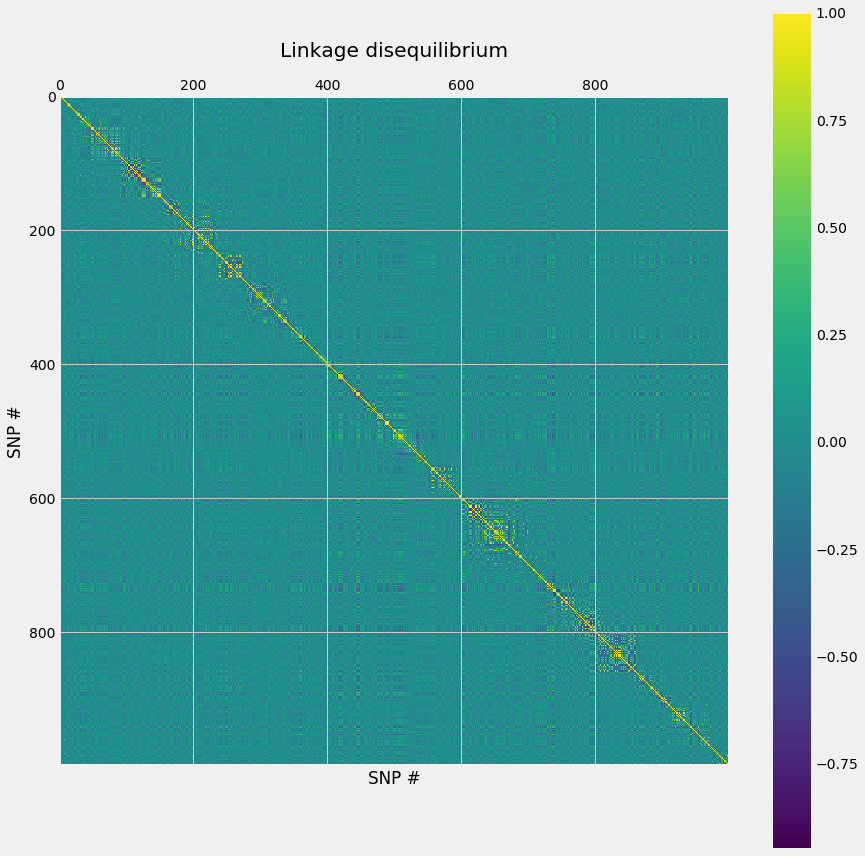

In [3]:
# Compute the LD matrix by taking the Pearson correlations.
LD_mat = SNP_df.iloc[0:1000, :].T.corr()

f = plt.figure(figsize=(15, 15))
plt.matshow(LD_mat, fignum=f.number)
cb = plt.colorbar()
plt.xlabel('SNP #')
plt.ylabel('SNP #')
plt.title('Linkage disequilibrium')
plt.show()

# 1) Describe the pattern you observe. What can we say about linkage disequilibrium as a function of distance between the SNPs? Does this make sense? What process (that we've covered) could account for this pattern?

# Answer: Off the diagonal, SNPs are generally uncorrelated with one another. However, near it, we see a block-like pixelation indicative of correlation between SNPs which are located near one another. This is due to recombination.

To perform a GWAS, we usually want to work with the genotype matrix. This requires we combine the chromosomes from each individual such that for each SNP we now have possible values of 0, 1, and 2. These values count the number of mutations at that genomic location.

In [4]:
# Create genotype matrix
x = SNP_df.iloc[:,np.arange(0,SNP_df.shape[1],2)]
y = SNP_df.iloc[:,np.arange(1,SNP_df.shape[1],2)]
y.columns = x.columns[:]
genotype_df = x+y

Let's quickly check whether we can see evidence that we have two different populations in our data by computing and inspecting the correlation between the individuals' genotypes.

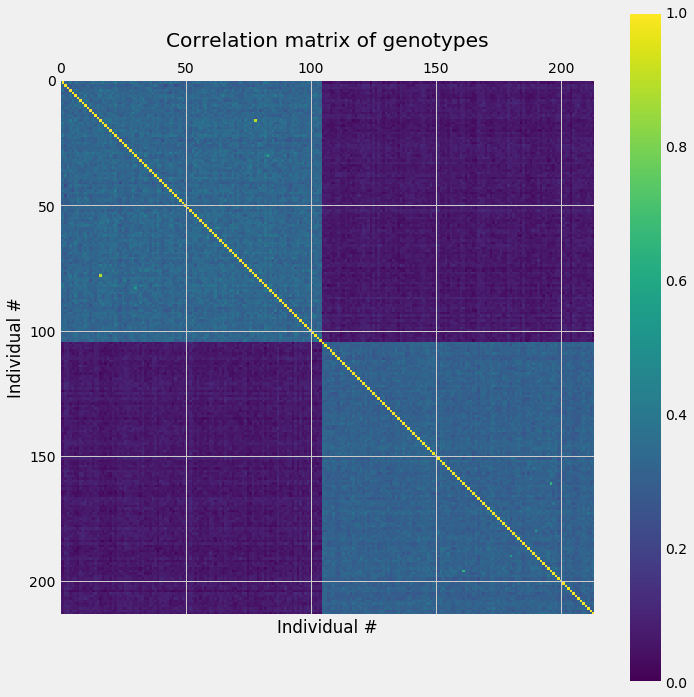

In [5]:
# Population structure matrix
individual_corr_df = genotype_df.corr()

f = plt.figure(figsize=(12, 12))
plt.matshow(individual_corr_df, fignum=f.number)
cb = plt.colorbar()
plt.xlabel('Individual #')
plt.ylabel('Individual #')
plt.title('Correlation matrix of genotypes')
plt.show()

# 2) How do you interpret what you observe? What might this portend for our further analyses?

# Answer: The correlation matrix has a block structure with 2 groups corresponding to the CEU and YRI populations. This could be problematic because ancestry is a confounding variable if we analyze these two populations jointly.

Now we're ready to perform our GWAS. Let's start by loading the phenotype for all our individuals.

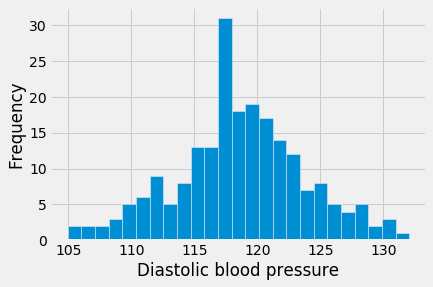

In [6]:
# Load phenotype data and look at a histogram
pheno_df = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Lab09/phenotype_obs.csv').iloc[0,:]

plt.hist(list(pheno_df), bins = 25)
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Frequency')
plt.show()

We want to determine the effect of each SNP on diastolic blood pressure. Since blood pressure is a quantitative trait, the naive way to do this is to perform a linear regression marginally for each SNP and then look at which ones are statistically significant.

In [7]:
# Perform linear regression for each SNP and extract the p-value
p_vals_vec = []
for i in np.arange(0, genotype_df.shape[0]):        
    SNP_vec = list(genotype_df.iloc[i,:])
    X = sm.add_constant(SNP_vec)
    model = sm.OLS(pheno_df, X).fit()
    p_vals_vec.append(model.pvalues[1])

# 3) Here we've computed our p-values from linear regression. However, we could've also obtained a different set of them from a permutation test. Let's say we have computed the correlation between the value of our trait of interest and the number of mutations at a given location. Describe how you would perform the permutation test with correlation as the test statistic. (Hint: look back at some older labs if you're stuck).

# Answer: We would permute the values of the trait among the individuals and then re-compute the correlation between the number of mutations and the trait value. We would store this value and repeat this procedure a large number of times in order to generate the null distribution of correlation under the assumption of no relationship between the mutation and the trait. We could then compute a p-value for our true observation from the null distribution we generate.

The way we often examine our results is via something called a "Manhattan plot". This plots the -log10 p-value for each SNP over the entire region of interest. Our usual threshhold of 0.05 is no longer suitable because of how many tests we're performing. Typically we adjust our cutoff, in this case using the Bonferroni correction.

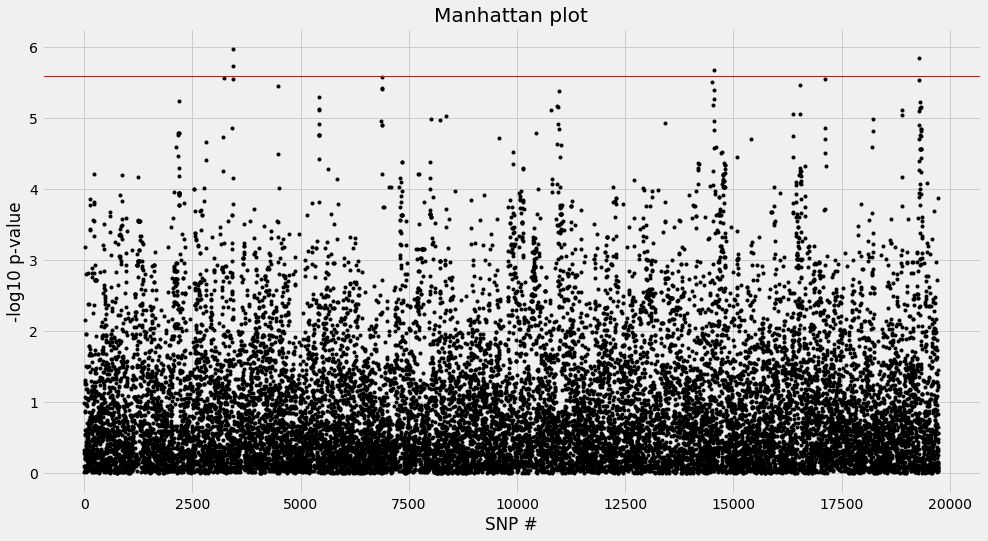

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(0, genotype_df.shape[0]), -np.log10(p_vals_vec), 'k.')
plt.xlabel('SNP #')
plt.ylabel('-log10 p-value')
plt.title('Manhattan plot')
plt.axhline(y = -np.log10(.05/genotype_df.shape[0]), linewidth=1, color='r')     # plot Bonferroni-corrected cutoff
plt.show()

# 4) What does the plot look like? Why might it be called a Manhattan plot? Can you explain what could be causing this phenomenon?

# Answer: It looks like a city skyline, much like the skyscrapers in Manhattan. This pattern indicates that there is a lot of spatial correlation in p-values, meaning that tests are giving similar results when SNPs are physically near one another. This is a consequence of linkage disequilibrium.

# 5) The high cutoff for significance comes from the fact that we have to perform many tests. However, the calculation of this cutoff makes the assumption that all the tests are independent. From our LD matrix plot earlier, we know that these tests are not independent because many SNPs are in LD with one another. Given these bits of information, can you suggest a strategy that mostly preserves our ability to detect regions associated with traits while reducing the number of tests we have to perform?

# Answer: We could choose a representative SNP from each LD block and only test on it. This would preserve much of our power while allowing us to perform far fewer tests. If we identify LD blocks associated with the trait, we can perform a more refined procedure later on (this is known as fine mapping).

Our data here actually contain 2 populations, one of which is of African ancestry and the other is of Northern/Western European ancestry. As we have discussed before with PCA, sometimes our results are confounded if population structure (i.e. different ancestries) is present in our data. This is particularly true in association studies.

Let's run the analyses again to see if separating our data gives different results.

In [9]:
ceu_geno = genotype_df.iloc[:, :105]
ceu_pheno = pheno_df.iloc[:105]

yri_geno = genotype_df.iloc[:, 105:]
yri_pheno = pheno_df.iloc[105:]

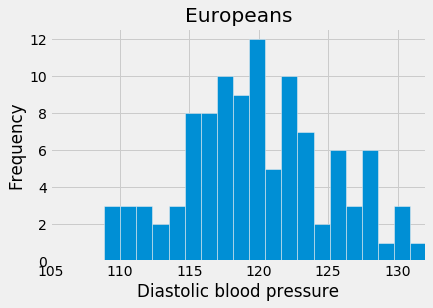

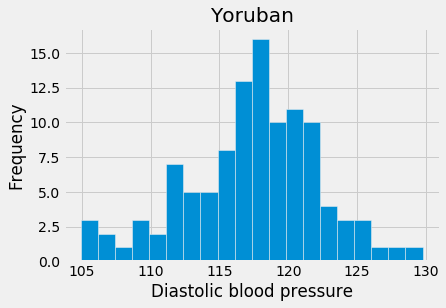

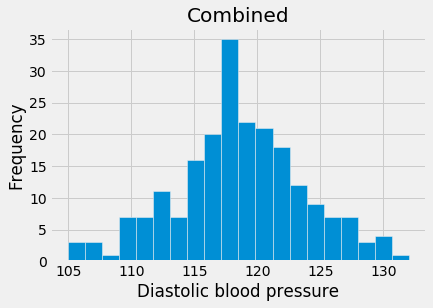

In [10]:
plt.hist(list(ceu_pheno), bins = 20)
plt.xlim((105, ceu_pheno.max()))
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Frequency')
plt.title('Europeans')
plt.show()

plt.hist(list(yri_pheno), bins = 20)
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Frequency')
plt.title('Yoruban')
plt.show()

plt.hist(list(pheno_df), bins = 20)
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Frequency')
plt.title('Combined')
plt.show()

# 6) Comment on the differences between the 3 histograms above. What do you notice about the means and spreads of each distribution?

# Answer: The histograms seem to be different once you stratify by population. In particular, the CEU group has a slightly higher mean and variance than the YRI.

In [11]:
#Use this cell to calculate the means of each distribution, if you'd like


In [12]:
#Let's perform a t-test to see if the observed difference in means is significant
stats.ttest_ind(ceu_pheno.values, yri_pheno.values)


Ttest_indResult(statistic=3.738681036018181, pvalue=0.0002379887323485819)

# 7) Based on the result of the t-test, is the difference between the two groups significant? Do you think this difference might affect our analysis?

# Answer: Yes, we obtain a significant result (this is also true if we use the rank-sum test). It's very possible that this difference is bleeding through into our combined GWAS, in which case it would detect SNPs which are different between the populations rather than ones which correlate with the trait itself. (Classic, real-world examples of this include significant hits for skin pigmentation genes when studying lactose persistance if Europeans and Africans are analyzed together)

In [13]:
# Perform linear regression for each SNP and extract the p-value
ceu_p_vals_vec = []
for i in np.arange(0, ceu_geno.shape[0]):        
    SNP_vec = list(ceu_geno.iloc[i,:])
    X = sm.add_constant(SNP_vec)
    model = sm.OLS(ceu_pheno, X).fit()
    ceu_p_vals_vec.append(model.pvalues[1])

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [14]:
yri_p_vals_vec = []
for i in np.arange(0, yri_geno.shape[0]):        
    SNP_vec = list(yri_geno.iloc[i,:])
    X = sm.add_constant(SNP_vec)
    model = sm.OLS(yri_pheno, X).fit()
    yri_p_vals_vec.append(model.pvalues[1])

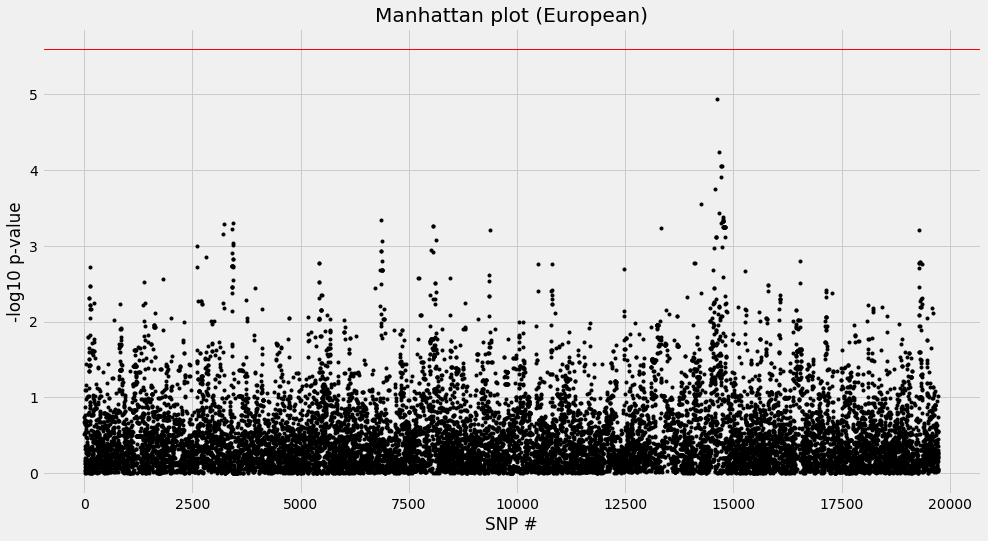

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(0, ceu_geno.shape[0]), -np.log10(ceu_p_vals_vec), 'k.')
plt.xlabel('SNP #')
plt.ylabel('-log10 p-value')
plt.title('Manhattan plot (European)')
plt.axhline(y = -np.log10(.05/ceu_geno.shape[0]), linewidth=1, color='r')     # plot Bonferroni-corrected cutoff
plt.show()

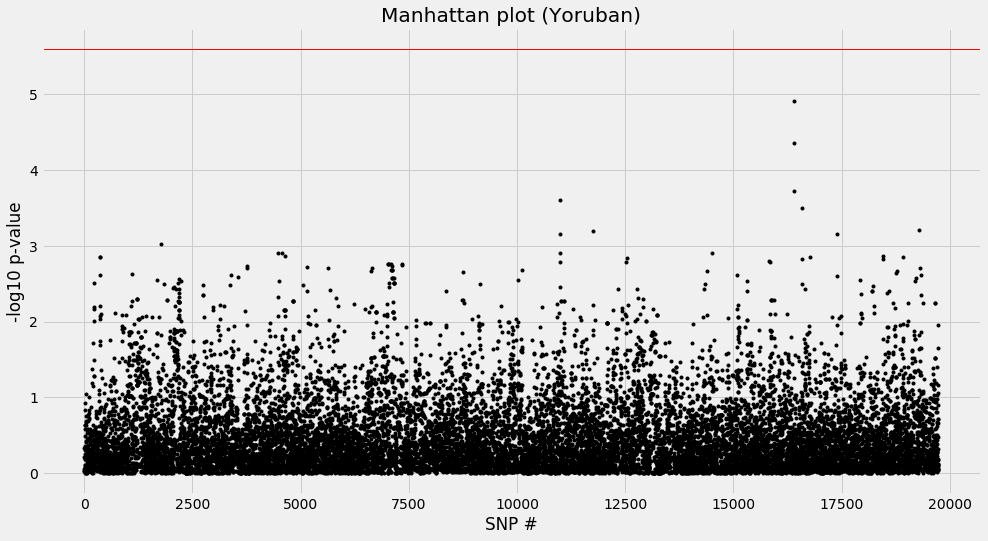

In [16]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(0, yri_geno.shape[0]), -np.log10(yri_p_vals_vec), 'k.')
plt.xlabel('SNP #')
plt.ylabel('-log10 p-value')
plt.title('Manhattan plot (Yoruban)')
plt.axhline(y = -np.log10(.05/yri_geno.shape[0]), linewidth=1, color='r')     # plot Bonferroni-corrected cutoff
plt.show()

# 8) When we run our linear regression on the the populations separately, do we see any significantly associated SNPs? Do the strongest associations appear to be at the same locus (Physical location on the chromosome) in the two populations?

# Answer: No, we no longer are able to identify any statistically significant locations. Comparison of the CEU and YRI Manhattan plots shows that their respective peaks actually occur at different locations.

GWAS comprise one component of the push towards personalized medicine. However, one potential issue is that the vast majority of studies have been done on individuals of European descent. Unfortunately, it turns out that these analyses fail to generalize well across different populations. This has led to a situation in which we have a characterization of genetic effects for, for example, disease risk in Europeans but not in individuals of other ethnicities, further deepening disparities in access to healthcare. Indeed, we can get an idea of this lack of generalizability even with an admittedly very small population on a chromosomal scale.

Another problem is that GWAS typically require very large sample sizes to detect anything but the simplest traits. As a result, many studies have been done on the same set of large data banks, but there remains much to do.

In [17]:
#ok = Notebook('Lab09_GWAS.ok')
#_ = ok.auth(inline=True)

In [18]:
# Submit the assignment.
#_ = ok.submit()